In [57]:
# Import necessary libraries for building a CNN with TensorFlow and download CIFAR-100 dataset
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandas.plotting import table
import pandas as pd
import datetime

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [58]:
# List physical devices
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("🚀 GPU(s) detected!")
    for gpu in gpus:
        print(f" - {gpu}")
    print("TensorFlow will use the GPU by default when available.")
else:
    print("⚠️ No GPU detected. Using CPU only.")

🚀 GPU(s) detected!
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow will use the GPU by default when available.


Training set shape: (40000, 32, 32, 3)
Validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


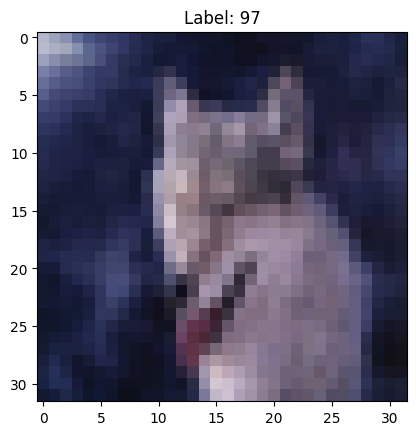

In [59]:
# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Split training data into training and validation sets (e.g., 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)

# ...existing code...

# Display the first image and label as a sample
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
plt.title(f"Label: {y_train[0][0]}")
plt.show()

In [60]:
# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomCrop(32, 32)
])

In [ ]:
weight_decay = 5e-4
dropout_rate = 0.4

model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,

    # Block 1
    layers.Conv2D(64, 5, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Conv2D(64, 5, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.AveragePooling2D(pool_size=2, strides=2),  # Use AveragePooling2D
    layers.Dropout(dropout_rate),

    # Block 2
    layers.Conv2D(128, 5, strides=2, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Conv2D(128, 5, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=2, strides=2),  # Use MaxPooling2D
    layers.Dropout(dropout_rate),

    # Block 3
    layers.Conv2D(256, 5, strides=2, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.Conv2D(256, 5, strides=1, padding='same', activation='relu',
                  kernel_regularizer=regularizers.l2(weight_decay)),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),  # Use GlobalAveragePooling2D for final spatial reduction
    layers.Dropout(dropout_rate),

    layers.Flatten(),
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(weight_decay)),
    layers.Dropout(dropout_rate),
    layers.Dense(100, activation='softmax')
])


Epoch 1/40


E0000 00:00:1749874326.580998    1727 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_17_1/dropout_32_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 - 29s - 47ms/step - accuracy: 0.0878 - loss: 4.4354 - val_accuracy: 0.1493 - val_loss: 3.9458 - learning_rate: 1.0000e-03
Epoch 2/40
625/625 - 25s - 40ms/step - accuracy: 0.1687 - loss: 3.9038 - val_accuracy: 0.2209 - val_loss: 3.6555 - learning_rate: 1.0000e-03
Epoch 3/40
625/625 - 25s - 39ms/step - accuracy: 0.2217 - loss: 3.6730 - val_accuracy: 0.2831 - val_loss: 3.4382 - learning_rate: 1.0000e-03
Epoch 4/40
625/625 - 25s - 40ms/step - accuracy: 0.2698 - loss: 3.5248 - val_accuracy: 0.2784 - val_loss: 3.5215 - learning_rate: 1.0000e-03
Epoch 5/40
625/625 - 23s - 37ms/step - accuracy: 0.3029 - loss: 3.4438 - val_accuracy: 0.2806 - val_loss: 3.5891 - learning_rate: 1.0000e-03
Epoch 6/40
625/625 - 24s - 39ms/step - accuracy: 0.3320 - loss: 3.3792 - val_accuracy: 0.3518 - val_loss: 3.2821 - learning_rate: 1.0000e-03
Epoch 7/40
625/625 - 24s - 39ms/step - accuracy: 0.3532 - loss: 3.3350 - val_accuracy: 0.3652 - val_loss: 3.2633 - learning_rate: 1.0000e-03
Epoch 8/40
625/625 - 25s

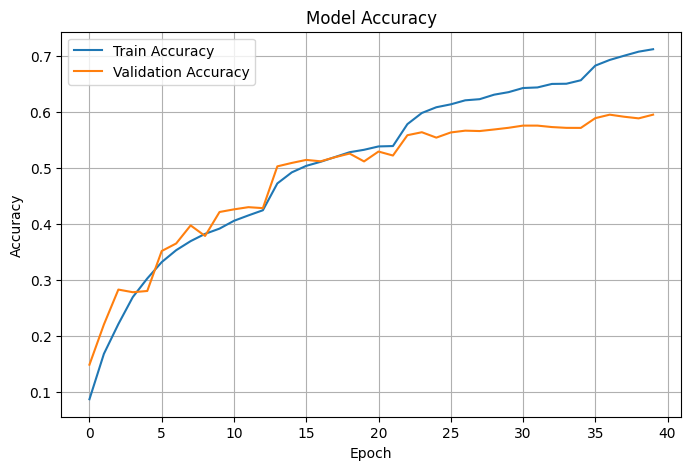

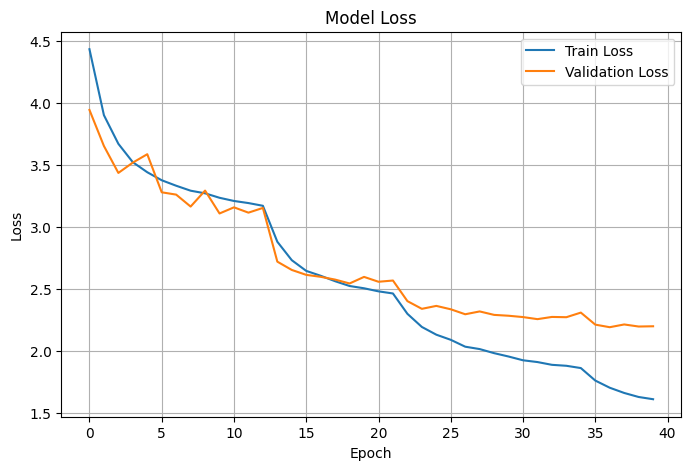

In [62]:
# --- Optimizer and Training Setup ---
batch_size = 64
epochs = 40

optimizer = AdamW(learning_rate=1e-3, weight_decay=weight_decay)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# --- Training ---
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

# --- Evaluation ---
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}")

# Plot training & validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [63]:
lrs = []
for i in range(len(history.history['loss'])):
    lr = float(model.optimizer.learning_rate)
    # If using a scheduler, get the actual value from the optimizer
    if hasattr(model.optimizer, 'lr'):
        lr = float(tf.keras.backend.get_value(model.optimizer.lr))
    elif hasattr(model.optimizer, 'learning_rate'):
        lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
    lrs.append(lr)

# Extract accuracy and loss history
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
    'Learning Rate': lrs
})

# Model architecture specs for reference
model_specs = (
    "Model Specs:\n"
    "- Conv2D: 5x5 kernel, mixed strides (1 and 2), ReLU, padding='same', L2 regularization (5e-4)\n"
    "- Block 1: AveragePooling2D (2x2)\n"
    "- Block 2: MaxPooling2D (2x2)\n"
    "- Block 3: GlobalAveragePooling2D\n"
    "- BatchNormalization after each Conv2D\n"
    "- 3 Conv blocks: 64, 128, 256 filters\n"
    "- Dropout: 0.4 after each block and dense\n"
    "- Flatten before dense layers\n"
    "- Dense: 256 units, ReLU, L2 regularization (5e-4)\n"
    "- Output: 100 units, softmax\n"
    "- Optimizer: AdamW (learning_rate=1e-3, weight_decay=5e-4)\n"
    "- Callbacks: EarlyStopping (patience=10), ReduceLROnPlateau (factor=0.5, patience=3, min_lr=1e-5)\n"
    "- Epochs: 40, Batch size: 64"
)

# Get current time for unique filename
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"training_history_table_with_specs_{now}.png"

# Create a figure with subplots for accuracy, loss, and the table
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2)

# Model specs text
ax0 = fig.add_subplot(gs[0, :])
ax0.axis('off')
ax0.text(0, 1, model_specs, fontsize=12, ha='left', va='top', family='monospace')

# Accuracy plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

# Save the table as a PNG image
# Table
ax3 = fig.add_subplot(gs[2, :])
ax3.axis('off')
tbl = table(ax3, history_df.round(4), loc='center', colWidths=[0.13]*len(history_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig(filename, bbox_inches='tight', dpi=200)
plt.close()

print(f"Training history table with plots saved as '{filename}'.")

Training history table with plots saved as 'training_history_table_with_specs_20250614_002815.png'.


## Comparative Analysis: 3x3 vs 5x5 Kernel Architectures on CIFAR-100

### **Performance Summary**

- **3x3 Kernel Model:**
  - **Test Accuracy:** ~63.2%
  - **Training/Validation Accuracy:** Both steadily increased, with validation accuracy closely tracking training accuracy.
  - **Loss:** Training and validation loss decreased smoothly, with minimal overfitting.
  - **Learning Rate:** Scheduler reduced LR from 0.001 to 0.0005 and 0.00025, aiding convergence.

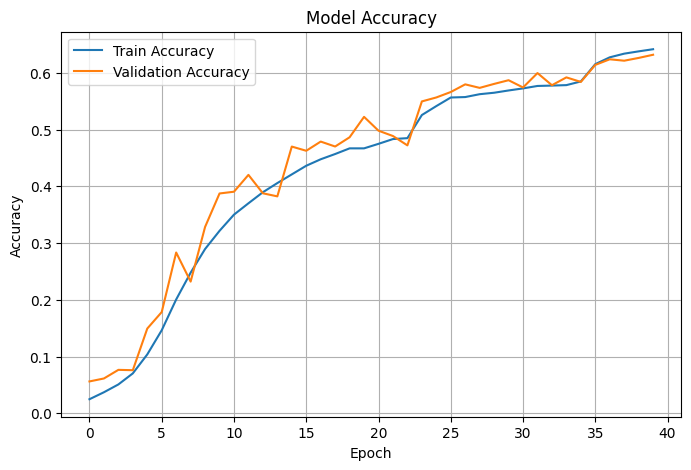

In [64]:
from IPython.display import Image, display

display(Image(filename='Model accuracy 3x3.png')) 

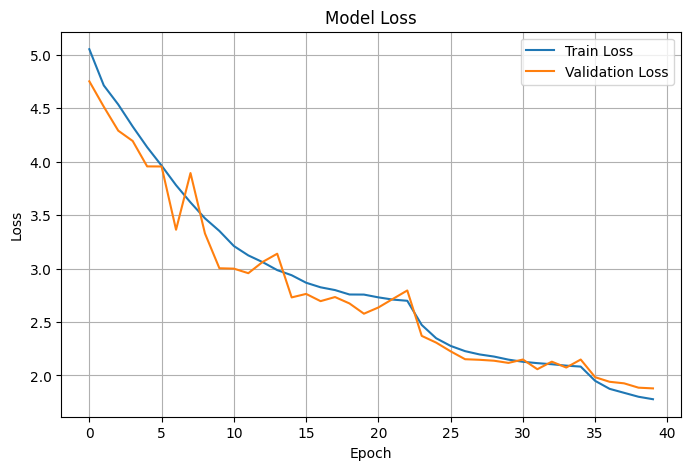

In [66]:
from IPython.display import Image, display

display(Image(filename='Model loss 3x3.png')) 


- **5x5 Kernel Model:**
  - **Test Accuracy:** ~59.6%
  - **Training Accuracy:** Reached ~71%, but validation accuracy plateaued around 59%.
  - **Loss:** Training loss continued to decrease, but validation loss plateaued and showed a wider gap, indicating mild overfitting.
  - **Learning Rate:** Scheduler reduced LR from 0.001 to 0.0005, 0.00025, and 0.000125, supporting fine-tuning.

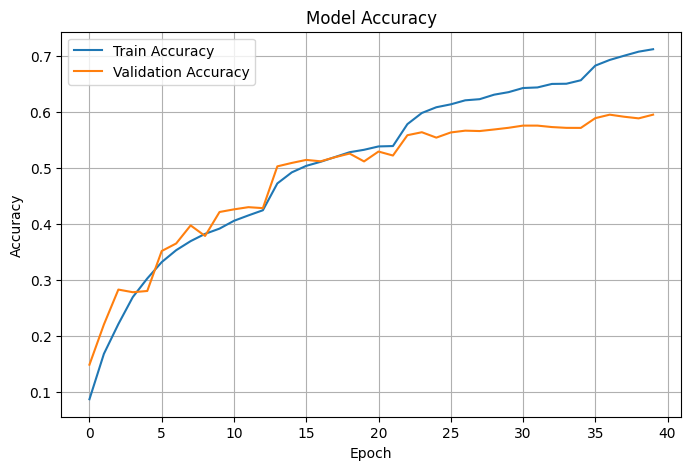

In [67]:
from IPython.display import Image, display

display(Image(filename='Model accuracy 5x5.png')) 

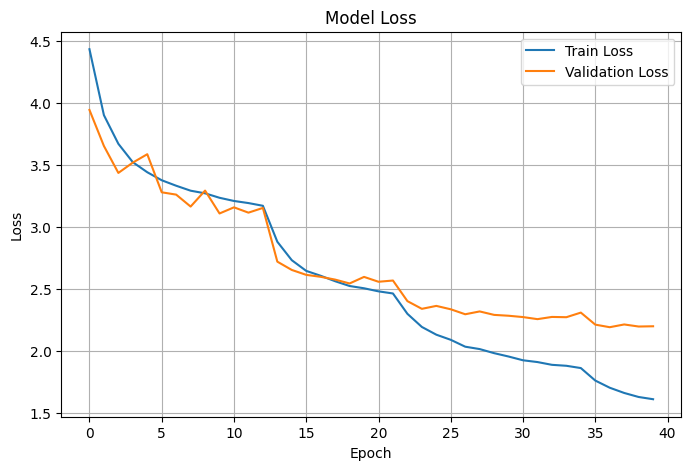

In [68]:
from IPython.display import Image, display

display(Image(filename='Model loss 5x5.png')) 

### **Impact of Kernel Size and Stride Choices**

- **3x3 kernels** are more effective for CIFAR-100, enabling deeper feature extraction with fewer parameters per layer and better generalization. They allow stacking more layers, capturing hierarchical features efficiently.
- **5x5 kernels** extract broader spatial features per layer but increase parameter count and risk overfitting, especially with limited data. They may miss finer details that smaller kernels can capture through deeper stacking.
- **Stride choices** affect spatial resolution: higher strides reduce feature map size faster, potentially losing information, while stride 1 preserves more detail for deeper processing.

### **Recommendations for More Complex Datasets**

- **Deeper/Residual Architectures:** Use deeper models or architectures with residual connections (e.g., ResNet, DenseNet) to improve feature learning and gradient flow.
- **Hybrid Kernel Sizes:** Combine 3x3 and 5x5 (or even 1x1) kernels within the same network to capture both fine and coarse features.
- **Advanced Data Augmentation:** Employ more aggressive augmentation (rotation, color jitter, cutout, mixup) to improve robustness.
- **Regularization:** Tune dropout and L2 regularization; consider label smoothing.
- **Transfer Learning:** Use pretrained models and fine-tune for complex or larger datasets.
- **Learning Rate Scheduling:** Experiment with cyclical or cosine annealing schedules for potentially better convergence.

### **Challenges**
- **Need for More Epochs:** Achieving decent accuracy with both models often required a large number of training epochs, especially without advanced techniques like transfer learning or sophisticated augmentation. This increased training time and computational demand.
- **Hyperparameter Tuning:** Both models were sensitive to hyperparameter choices (e.g., learning rate, dropout, regularization, optimizer). Careful and sometimes time-consuming tuning was necessary to achieve optimal results and avoid overfitting or underfitting.

### **Conclusion**

The 3x3 kernel architecture outperformed the 5x5 version on CIFAR-100, demonstrating better generalization and less overfitting. Smaller kernels with appropriate depth and stride allow for richer, hierarchical feature extraction. For more complex datasets, leverage deeper or hybrid architectures, advanced augmentation, and transfer learning to further boost performance.